In [1]:
import numpy as np
import rydiqule as rq
import matplotlib.pyplot as plt

In [2]:
%load_ext line_profiler

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
rydberg_target_state = [150, 2, 2.5, 0.5]  
rydberg_excited_state = [149, 3, 3.5, 0.5]

RbSensor_time = rq.Cell('Rb85', *rq.D2_states("Rb85"), rydberg_target_state, rydberg_excited_state, 
                        gamma_transit=2*np.pi*1)
RbSensor_ss = rq.Cell('Rb85', *rq.D2_states("Rb85"), rydberg_target_state, rydberg_excited_state, 
                        gamma_transit=2*np.pi*1)

In [5]:
[n,l,j,m] = RbSensor_time.states_list()[2]
[n2, l2, j2, m2]  = RbSensor_time.states_list()[3]
rf_freq = RbSensor_time.atom.getTransitionFrequency(n2,l2,j2,n,l,j)*1E-6
rf_rabi = 25 #Mrad/s

In [6]:
red_laser = {'states':(0,1), 'rabi_frequency':2*np.pi*0.6, 'detuning':0,
            'kvec':2*np.pi/780e-3*np.array([1,0,0])}
blue_laser = {'states':(1,2), 'rabi_frequency':2*np.pi*1.0, 'detuning':0,
             'kvec':2*np.pi/480e-3*np.array([-1,0,0])}
local_oscillator_ss = {'states':(2,3), 'rabi_frequency':rf_rabi, 'detuning':0}

RbSensor_ss.add_couplings(red_laser, blue_laser, local_oscillator_ss)
RbSensor_time.add_couplings(red_laser,blue_laser)

In [7]:
print(rf_freq)

-658.5872652398125


## Non-RWA Solves ##

In [8]:
def sig_and_LO(omega_0, delta, beta):
    def fun(t):
        return np.sin(omega_0*t)+beta*np.sin((omega_0+delta)*t)
    return fun

In [9]:
omega_0 = 2*np.pi*rf_freq
delta = 5 
beta = 0.05

In [10]:
rf_transition = {'states':(2,3), 'rabi_frequency':rf_rabi, 'time_dependence': sig_and_LO(omega_0, delta, beta )}
RbSensor_time.add_couplings(rf_transition)

In [11]:
sol_init = rq.solve_steady_state(RbSensor_ss)

In [12]:
%%time
sample_num=250
end_time = 10

time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num,  init_cond=sol_init.rho)

print(time_sol_beat.rho.shape)

(250, 15)
CPU times: total: 8.86 s
Wall time: 8.86 s


In [13]:
%%time
sample_num=250
end_time = 10

time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num,  init_cond=sol_init.rho,
                             solver='nbkode')

print(time_sol_beat.rho.shape)

(250, 15)
CPU times: total: 17.8 s
Wall time: 18.3 s


In [14]:
%%time
sample_num=250
end_time = 10

time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num,  init_cond=sol_init.rho,
                             solver='cyrk')

print(time_sol_beat.rho.shape)

(250, 15)
CPU times: total: 12.5 s
Wall time: 11.7 s


In [15]:
%%time
sample_num=250
end_time = 10

time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num,  init_cond=sol_init.rho,
                             solver='nbrk')

print(time_sol_beat.rho.shape)

(250, 15)
CPU times: total: 17.3 s
Wall time: 18 s


(0.57, 0.575)

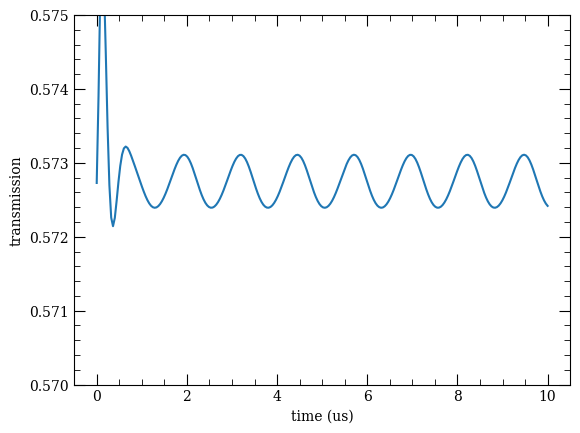

In [16]:
fig, ax = plt.subplots()
transmission = time_sol_beat.rho[:,3]
ax.plot(time_sol_beat.t, rq.get_transmission_coef(time_sol_beat, RbSensor_time, .001))
ax.set_xlabel("time (us)");
ax.set_ylabel('transmission');
ax.set_ylim(bottom = .57, top = .575)

## RWA solves ##

In [17]:
def sig_LO_RWA(det, beta):
    def fun(t):
        return 1+beta*np.exp(1j*det*t)
    return fun

In [18]:
rf_transition = {'states':(2,3), 'rabi_frequency':rf_rabi, 'detuning':0, 'time_dependence': sig_LO_RWA(delta, beta )}
RbSensor_time.add_couplings(rf_transition)

In [19]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num)

CPU times: total: 31.2 ms
Wall time: 36.1 ms


In [20]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num, solver='nbkode')

CPU times: total: 6.61 s
Wall time: 6.82 s


In [21]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num, solver='cyrk')

CPU times: total: 531 ms
Wall time: 577 ms


In [22]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num, solver='nbrk')

CPU times: total: 5.03 s
Wall time: 5.61 s


(0.57, 0.575)

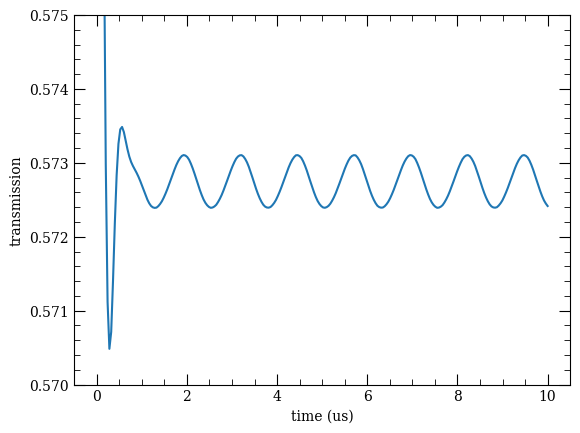

In [23]:
fig, ax = plt.subplots()
ax.plot(time_sol_beat.t, rq.get_transmission_coef(time_sol_beat, RbSensor_time, .001))
ax.set_xlabel("time (us)");
ax.set_ylabel('transmission');
ax.set_ylim(bottom = .57, top = .575)

## Doppler RWA solves ##

In [24]:
rf_transition = {'states':(2,3), 'rabi_frequency':rf_rabi, 'detuning':0,
                 'time_dependence': sig_LO_RWA(delta, beta)}
RbSensor_time.add_couplings(rf_transition)

In [25]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num,
                             doppler=True)

CPU times: total: 3.67 s
Wall time: 467 ms


In [26]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num,
                             doppler=True, solver='nbkode')

CPU times: total: 15 s
Wall time: 7.54 s


In [27]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num,
                             doppler=True, solver='cyrk')

CPU times: total: 5.05 s
Wall time: 1.42 s


In [28]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num,
                             doppler=True, solver='nbrk')

CPU times: total: 6.61 s
Wall time: 5.55 s


(0.586, 0.589)

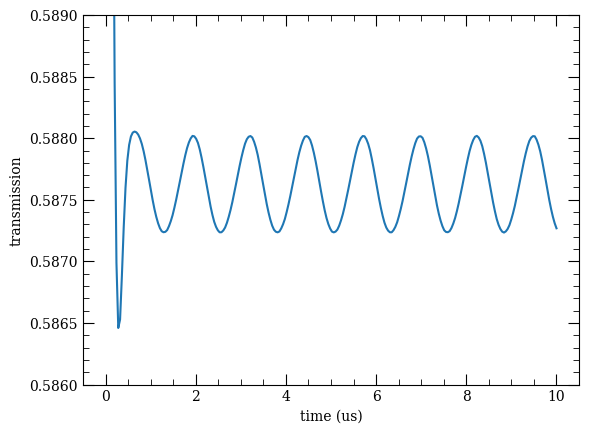

In [29]:
fig, ax = plt.subplots()
ax.plot(time_sol_beat.t, rq.get_transmission_coef(time_sol_beat, RbSensor_time, .001))
ax.set_xlabel("time (us)");
ax.set_ylabel('transmission');
ax.set_ylim(bottom = .586, top = .589)

## Large Doppler RWA solves ##

In [30]:
rf_detunings = np.linspace(0, 20, 101)
rf_transition_det = {'states':(2,3), 'rabi_frequency':rf_rabi,
                 'detuning':2*np.pi*rf_detunings,
                 'time_dependence': sig_LO_RWA(delta, beta)}
RbSensor_time.add_couplings(rf_transition_det)

In [31]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num,
                             doppler=True)

CPU times: total: 35min 51s
Wall time: 4min 31s


In [32]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num,
                             doppler=True, solver='nbkode')

CPU times: total: 44min 21s
Wall time: 5min 39s


In [33]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num,
                             doppler=True, solver='cyrk',
                             n_slices=13)

Breaking equations of motion into 13 sets of equations...


ValueError: Inital condition shape (8, 101, 15) does not match expected
        soulution shape (561, 8, 15)

In [34]:
%%time
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num,
                             doppler=True, solver='nbrk')

CPU times: total: 5min 21s
Wall time: 5min 19s


(0.586, 0.589)

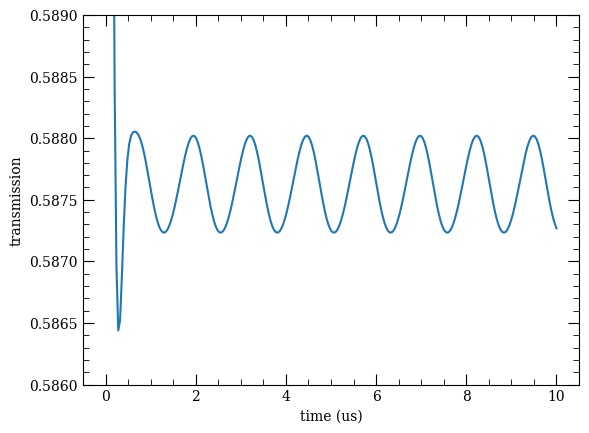

In [35]:
fig, ax = plt.subplots()
ax.plot(time_sol_beat.t, rq.get_transmission_coef(time_sol_beat, RbSensor_time, .001)[0])
ax.set_xlabel("time (us)");
ax.set_ylabel('transmission');
ax.set_ylim(bottom = .586, top = .589)